In [1]:
import sys
sys.path.append('..')

In [2]:
import CAT
import json
import torch
import logging
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [3]:
def setuplogger():
    root = logging.getLogger()
    root.setLevel(logging.INFO)
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter("[%(levelname)s %(asctime)s] %(message)s")
    handler.setFormatter(formatter)
    root.addHandler(handler)

In [4]:
setuplogger()

In [5]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
# tensorboard
log_dir = f"../logs/{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M')}/"
print(log_dir)
writer = SummaryWriter(log_dir)

../logs/2021-03-01-21:19/


In [7]:
# choose dataset here
dataset = 'assistment'
# modify config here
config = {
    'learning_rate': 0.0025,
    'batch_size': 2048,
    'num_epochs': 8,
    'num_dim': 1,
    'device': 'cpu',
}
# fixed test length
test_length = 10
# choose strategies here
strategies = [CAT.strategy.MFIStrategy(), CAT.strategy.KLIStrategy()]
# modify checkpoint path here
ckpt_path = '../ckpt/checkpoint.pt'

In [8]:
# read datasets
test_triplets = pd.read_csv(f'../data/{dataset}/test_triples.csv', encoding='utf-8').to_records(index=False)
concept_map = json.load(open(f'../data/{dataset}/concept_map.json', 'r'))
concept_map = {int(k):v for k,v in concept_map.items()}
metadata = json.load(open(f'../data/{dataset}/metadata.json', 'r'))

In [9]:
test_data = CAT.dataset.AdapTestDataset(test_triplets, concept_map,
                                        metadata['num_test_students'], 
                                        metadata['num_questions'], 
                                        metadata['num_concepts'])

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
auc_history = {}
cov_history = {}
iters = {}
for strategy in strategies:
    model = CAT.model.IRTModel(**config)
    model.init_model(test_data)
    model.adaptest_load(ckpt_path)
    test_data.reset()
    auc_history[strategy.name] = []
    cov_history[strategy.name] = []
    iters[strategy.name] = []
    
    logging.info('-----------')
    logging.info(f'start adaptive testing with {strategy.name} strategy')

    logging.info(f'Iteration 0')
    iters[strategy.name].append(0)
    # evaluate models
    results = model.evaluate(test_data)
    auc_history[strategy.name].append(results['auc'])
    cov_history[strategy.name].append(results['cov'])
    for name, value in results.items():
        logging.info(f'{name}:{value}')
        
    for it in range(1, test_length + 1):
        logging.info(f'Iteration {it}')
        # select question
        selected_questions = strategy.adaptest_select(model, test_data)
        for student, question in selected_questions.items():
            test_data.apply_selection(student, question)
        # update models
        model.adaptest_update(test_data)
        # evaluate models
        results = model.evaluate(test_data)
        # log results
        iters[strategy.name].append(it)
        auc_history[strategy.name].append(results['auc'])
        cov_history[strategy.name].append(results['cov'])
        for name, value in results.items():
            logging.info(f'{name}:{value}')
            writer.add_scalars(name, {strategy.name: value}, it)

[INFO 2021-03-01 21:20:10,230] -----------
[INFO 2021-03-01 21:20:10,231] start adaptive testing with Maximum Fisher Information Strategy strategy
[INFO 2021-03-01 21:20:10,231] Iteration 0
[INFO 2021-03-01 21:20:10,260] auc:0.6484533447389293
[INFO 2021-03-01 21:20:10,262] cov:0.0
[INFO 2021-03-01 21:20:10,262] Iteration 1
[INFO 2021-03-01 21:20:11,768] auc:0.6492874695641851
[INFO 2021-03-01 21:20:11,770] cov:0.0503951833541452
[INFO 2021-03-01 21:20:11,773] Iteration 2
[INFO 2021-03-01 21:20:13,255] auc:0.6504904035191303
[INFO 2021-03-01 21:20:13,255] cov:0.09758199115948935
[INFO 2021-03-01 21:20:13,256] Iteration 3
[INFO 2021-03-01 21:20:14,841] auc:0.6521533779951826
[INFO 2021-03-01 21:20:14,843] cov:0.13904934331124966
[INFO 2021-03-01 21:20:14,845] Iteration 4
[INFO 2021-03-01 21:20:16,413] auc:0.6533600336989795
[INFO 2021-03-01 21:20:16,414] cov:0.1810611882609775
[INFO 2021-03-01 21:20:16,415] Iteration 5
[INFO 2021-03-01 21:20:17,927] auc:0.6548746560294985
[INFO 2021-03-

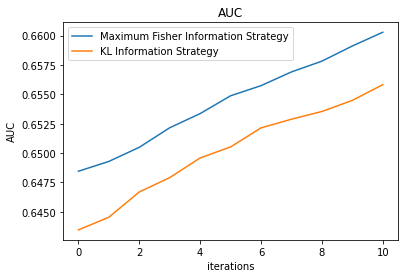

In [12]:
for strategy in strategies:
    plt.plot(iters[strategy.name], auc_history[strategy.name], label=strategy.name)
plt.title('AUC')
plt.xlabel('iterations')
plt.ylabel('AUC')
plt.legend()
plt.show()   

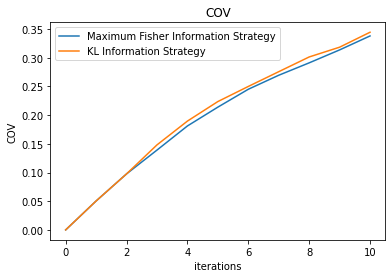

In [13]:
for strategy in strategies:
    plt.plot(iters[strategy.name], cov_history[strategy.name], label=strategy.name)
plt.title('COV')
plt.xlabel('iterations')
plt.ylabel('COV')
plt.legend()
plt.show() 